## **Load *Monod*+meK-Means and Packages**

In [31]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/')

In [32]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [33]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import scipy.stats

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report

import os

import sklearn
import scanpy as sc
import anndata

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## **Load Metadata and Select Genes for Inference Across Conditions**

In [35]:
#Test with controls for now, and remove later if necessary 

In [36]:
meta_path = "/home/tchari/metadata/"
meta = pd.read_csv(meta_path+'replogle_GSM4367984_concat_identities.csv')
meta.head()

,cell_barcode,guide_identity,num_guides,A,B,representation,single,double,essential,control,...,target_A,target_B,umi_A,umi_B,read_count,UMI_count,coverage,good_coverage,number_of_cells,gemgroup
0,AAACCCAAGATCCGAG-5,sgNegCtrl02093a_sgFDPSb,2,sgNegCtrl02093a,sgFDPSb,4.0,1.0,0.0,0.0,0.0,...,Non-Targeting,ENSG00000160752,191,2107,100,100,2,True,1,5
1,AAACCCAAGCATGAAT-3,sgNegCtrl8a_sgNegCtrl3b,2,sgNegCtrl8a,sgNegCtrl3b,2.0,0.0,0.0,0.0,1.0,...,Non-Targeting,Non-Targeting,1053,250,100,100,2,True,1,3
2,AAACCCAAGGCACCAA-3,sgHMGCRa_sgFDPSb,2,sgHMGCRa,sgFDPSb,1.0,0.0,1.0,0.0,0.0,...,ENSG00000113161,ENSG00000160752,2412,1431,100,100,2,True,1,3
3,AAACCCAAGGCATGGT-1,sgHUS1_2a_sgFDPS_2b,2,sgHUS1_2a,sgFDPS_2b,2.0,0.0,1.0,0.0,0.0,...,ENSG00000136273,ENSG00000160752,136,83,100,100,2,True,1,1
4,AAACCCAAGGGTACAC-6,sgHUS1_2a_sgFDPSb,2,sgHUS1_2a,sgFDPSb,2.0,0.0,1.0,0.0,0.0,...,ENSG00000136273,ENSG00000160752,45,48,100,100,2,True,1,6


In [37]:
ids = list(meta['guide_identity'].value_counts().index)
counts = list(meta['guide_identity'].value_counts())

saveCounts = pd.DataFrame()
saveCounts['guide_identity'] = ids
saveCounts['cells'] = counts
saveCounts.head()

,guide_identity,cells
0,sgNegCtrl02093a_sgFDPSb,1921
1,sgHMGCRa_sgHUS1b,1557
2,sgNegCtrl02093a_sgHUS1b,1513
3,sgNegCtrl02093a_sgNegCtrl3b,1465
4,sgHUS1a_sgFDPSb,1383


In [8]:
saveCounts[saveCounts['guide_identity'].isin(['sgNegCtrl4a_sgNegCtrl3b'])] 
#['sgHUS1_2a_sgFDPS_2b'],['sgHUS1_2a_sgNegCtrl3b'],['sgNegCtrl02093a_sgFDPS_2b']
#['sgPMVKa_sgFDPSb'],['sgPMVKa_sgNegCtrl3b'],['sgNegCtrl02093a_sgFDPSb']


,guide_identity,cells
11,sgNegCtrl4a_sgNegCtrl3b,780


In [9]:
ctrls = ['sgNegCtrl02093a_sgNegCtrl3b','sgNegCtrl4a_sgNegCtrl3b']  #CTRL for sgHUS1_2a_sgFDPS_2b from study

ctrl_bars = list(meta.cell_barcode[meta.guide_identity.isin(ctrls)])

conds_only = ['sgHUS1_2a_sgFDPS_2b','sgHUS1_2a_sgNegCtrl3b','sgNegCtrl02093a_sgFDPS_2b'] 
#['sgPMVKa_sgFDPSb','sgPMVKa_sgNegCtrl3b','sgNegCtrl02093a_sgFDPSb']

filt_ids = conds_only+ctrls   

len(filt_ids)

4

In [10]:
filt_bars = list(meta.cell_barcode[meta.guide_identity.isin(filt_ids)])

In [11]:
filt_conds_bars = list(meta.cell_barcode[meta.guide_identity.isin(conds_only)])

**For all pair conditions, find matching single conds and extract important genes**

In [295]:
import random

In [296]:
def input_for_sel(S1,S2,SC):
    '''
    Take in S counts for cond11,2,and control
    Normalize/scale S counts for test/train data for classifier
    Output normalized data (only for cond1/2 and control)
    '''
    
    X1 = S1 #cellxgene
    X2 = S2

    X_ctrl = SC
    
    min_size = np.min([X1.shape[0],X2.shape[0],X_ctrl.shape[0]])
    sub_inds = [] 
    for x in [X1,X2,X_ctrl]:
         sub_inds += [random.sample(range(x.shape[0]),min_size)] #Keep equal sized samples
            
    #sub_inds = random.sample(range(X_ctrl.shape[0]),X2.shape[0])
    X1 = X1[sub_inds[0],:]
    X2 = X2[sub_inds[1],:]
    X_ctrl = X_ctrl[sub_inds[2],:]

    X_conds = np.concatenate((X1,X2),axis=0) #X_both


    Y_conds = ['Cond1']*X1.shape[0]+['Cond2']*X2.shape[0] #+[dataset_names[inds[2]]]*X_both.shape[0]
    Y_conds_ctrl = Y_conds + ['Ctrl']*X_ctrl.shape[0]

    Y_conds = np.array(Y_conds)
    Y_conds_ctrl = np.array(Y_conds_ctrl)

    #dataset_names[i]

    #Scale cell reads, * median_reads/reads
    condTot = np.sum(X_conds,axis=1)
    median = np.median(condTot)
    ctrlTot = np.sum(X_ctrl,axis=1)
    facts = median/condTot
    factsCtrl = median/ctrlTot


    X_conds_norm = X_conds*np.repeat(facts.reshape(-1, 1), X_conds.shape[1], 1)
    X_ctrl_norm = X_ctrl*np.repeat(factsCtrl.reshape(-1, 1), X_ctrl.shape[1], 1)

    #Scale controls to same median
    X_conds_ctrl_norm = np.concatenate((X_conds_norm,X_ctrl_norm),axis=0)

    #From each cond, subtract ctrl mean and /std dev (Z-normalization)
    ctrl_mu = np.mean(X_ctrl_norm,axis=0) #For each gene
    ctrl_std = np.std(X_ctrl_norm,axis=0)


    X_conds_norm = (X_conds_norm-ctrl_mu)/(ctrl_std+1e-4) #Can lead to divide by zeros
    X_conds_ctrl_norm = (X_conds_ctrl_norm-ctrl_mu)/(ctrl_std+1e-4)
    
    return X_conds_ctrl_norm, Y_conds_ctrl


In [297]:
def sel_genes(X_conds_ctrl_norm ,Y_conds_ctrl,g_names_2, test_size=0.2,n_jobs = 10,num_features = 100):
    '''
    Take in scaled counts for cond1/2, & control,.
    Split data into test/train for classifier and extract top predictive genes.
    Output top genes for prediction condition label.
    '''
    
    test_size = test_size
    n_jobs = n_jobs

    X = X_conds_ctrl_norm 
    Y = Y_conds_ctrl

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42, stratify=Y)

    #From https://github.com/thomasmaxwellnorman/Perturbseq_GI/blob/3b25109aeb9c0c2026bd70abd50304a0ad4e5395/perturbseq/differential_expression.py#L213
    f_repr = 100
    # n_feat * 2 because the training matrix is extended with n shadow features
    multi = ((X_train.shape[1] * 2) / (np.sqrt(X_train.shape[1] * 2) * 10))
    n_estimators = int(multi * f_repr)
    #print('n_estimators: ',n_estimators)

    #.fit()
    clf_tree = ExtraTreesClassifier(n_jobs=n_jobs, n_estimators=n_estimators, class_weight='balanced', random_state=42)
    clf_tree.fit(X_train, Y_train)

    #.predict() on X_test
    Y_pred = clf_tree.predict(X_test)

    #get accuracy_score and classification_report
    acc = accuracy_score(Y_test, Y_pred)
    print('Feature prediction accuracy (test size: {1:.1f}%): {0}\n'.format(acc, 100*test_size))
    
    print('Unpredicted labels: ', set(Y_test) - set(Y_pred))
   
    
    report = classification_report(Y_test, Y_pred)
    print(report)


    #get feature_importances
    num_features = num_features #Top 100 genes for now

    idx = np.argsort(clf_tree.feature_importances_)[::-1]
    gene_indices = idx[0:num_features]
    top_gene_names = g_names_2[gene_indices] 
    
    plt.scatter(range(len(idx)),clf_tree.feature_importances_[idx])
    plt.vlines(f_repr,np.min(clf_tree.feature_importances_[idx]),np.max(clf_tree.feature_importances_[idx]))
    
    return top_gene_names


In [270]:
#Not 'Neg' paired conds
notNeg = [f for f in filt_ids if 'Neg' not in f]

In [271]:
first = [conds_only[1]]
secnd = [conds_only[2]]


In [12]:
#Get full count matrices and barcodes
ds = lp.connect('/home/tchari/counts/replogle_crispr/loom/allcrispr.loom')
U = ds.layers['unspliced'][:].T
S = ds.layers['spliced'][:].T
bars = ds.ca['barcode']
g_names = ds.ra['gene_name']
ds.close()

In [13]:
S.shape

(9565, 36601)

In [14]:
#Select genes to begin with that have enough U/S counts
filt_param={
        "min_U_mean": 0.01,
        "min_S_mean": 0.01,
        "max_U_max": 400,
        "max_S_max": 400,
        "min_U_max": 3,
        "min_S_max": 3,
    }

expr_filt = monod.preprocess.threshold_by_expression(S.T,U.T,
                                                     filt_param) #[:,np.isin(bars,filt_bars)]

In [15]:
np.sum(expr_filt)

3210

In [16]:
annots=pd.read_csv('/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3',delim_whitespace=True,header=None)
print(annots.head())

filt_markers = [m for m in g_names[expr_filt] if m in list(annots[0])]
len(filt_markers)

       0      1    2   3   4   5   6   7   8   9   ...  39  40  41  42  43  \
0    TNMD  14950   48  23  10   5   2   2   2   2  ...   0   0   0   0   0   
1    DPM1  23689   98  38  25  17  10   6   5   5  ...   0   0   0   0   0   
2   SCYL3  44637  132  51  20  13   9   7   6   4  ...   0   0   0   0   0   
3  TSPAN6  12884   43  18  13   8   3   2   2   1  ...   0   0   0   0   0   
4     FGR  23122   41  18   8   4   1   1   1   1  ...   0   0   0   0   0   

   44  45  46  47  48  
0   0   0   0   0   0  
1   0   0   0   0   0  
2   0   0   0   0   0  
3   0   0   0   0   0  
4   0   0   0   0   0  

[5 rows x 49 columns]


3177

In [17]:
#Get boolean filter for genes which are also in annotation file
expr_filt2 = np.isin(g_names,filt_markers)

In [18]:
g_names_2 = g_names[expr_filt2]

In [19]:
#How many genes in annotation and with enough U/S counts
np.sum(expr_filt2)

3177

In [334]:
#Filter for control condition cells
ctrl_S = S[np.isin(bars,ctrl_bars),:]

In [335]:
#Filter control cells for selected genes
ctrl_S = ctrl_S[:,expr_filt2] 
ctrl_S.shape

(780, 8223)

In [336]:
# all_ids = list(saveCounts['guide_identity'][(saveCounts['cells'] >  100)])

sgHUS1_2a_sgNegCtrl3b + sgNegCtrl02093a_sgFDPS_2b
Feature prediction accuracy (test size: 20.0%): 0.5681818181818182

Unpredicted labels:  set()
              precision    recall  f1-score   support

       Cond1       0.48      0.49      0.49        88
       Cond2       0.76      0.62      0.69        88
        Ctrl       0.50      0.59      0.54        88

    accuracy                           0.57       264
   macro avg       0.58      0.57      0.57       264
weighted avg       0.58      0.57      0.57       264



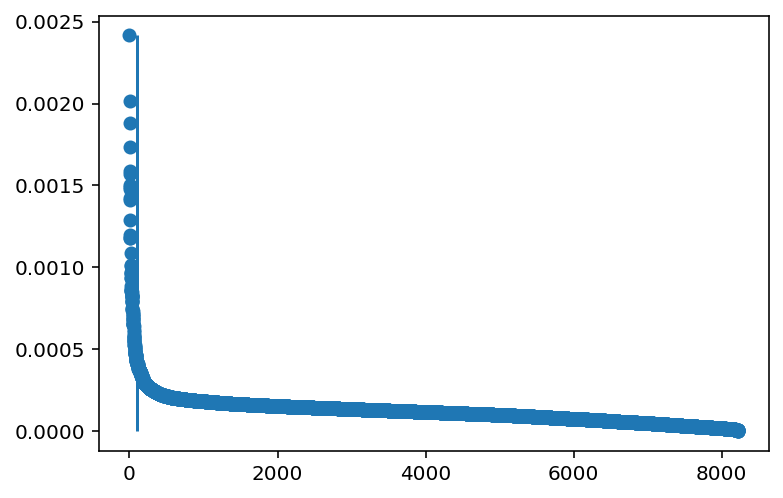

In [337]:
#Get single conds for first and secnd conds
all_gs_forinf = []
for g in range(len(first)):
    g1 = first[g]
    g2 = secnd[g]
    
    print(g1+' + '+g2)
    
    #sub U and S matrices
    bars1 = list(meta.cell_barcode[meta.guide_identity.isin([g1])])
    bars2 = list(meta.cell_barcode[meta.guide_identity.isin([g2])])
    
    if len(bars1) > 0 and len(bars2) > 0:  #May be some guides with no Neg ctrl pair in filtered list
        S1 = S[np.isin(bars,bars1),:]
        S1 = S1[:,expr_filt2]
        S2 = S[np.isin(bars,bars2),:]
        S2 = S2[:,expr_filt2]

        X,Y = input_for_sel(S1,S2,ctrl_S)
        imp_genes = sel_genes(X,Y,g_names_2,num_features=50) #How many top genes to select for each condition

        all_gs_forinf += list(imp_genes)
    else:
        print('no cells for '+str(g))
    

    
    
    
    

In [338]:
all_gs_forinf = np.unique(all_gs_forinf)
len(all_gs_forinf)

50

In [339]:
final_filt = np.isin(g_names,all_gs_forinf)

In [20]:
#Make anndata with conditions and get most variable
only_conds_S = S[:,:] #np.isin(bars,filt_conds_bars)
only_conds_S = only_conds_S[:,expr_filt2]
adata = anndata.AnnData(only_conds_S)

adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.var_names = g_names_2

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [21]:
all_gs_forinf = list(adata.var_names[adata.var.highly_variable])
final_filt = np.isin(g_names,all_gs_forinf)
np.sum(final_filt)

624

## **Set up Files for Inference and Select Cell Barcodes**

In [22]:
ks = [3,5] #K options for meK-Means
num_ks = len(ks) #Number of Ks to try

In [23]:
#Set  up output file names for inference run results

#Make names for each of the K runs
clus_names = ['k'+str(run_k) for run_k in ks]

#Output file names
dataset_names = ['meK_replogle_'+y  for y in clus_names]
print('Runs: ',dataset_names)

Runs:  ['meK_replogle_k3', 'meK_replogle_k5']


In [24]:
#Set reference data filepaths
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200525_genome_polyA_cum_3'

#Attribute names in loom file, same as in standard kallisto|bustools --lamanno output
attribute_names=[('unspliced','spliced'),'gene_name','barcode']

loom_filepaths = ['/home/tchari/counts/replogle_crispr/loom/allcrispr.loom']*num_ks #All runs use the same loom file
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

loom_filepaths:  ['/home/tchari/counts/replogle_crispr/loom/allcrispr.loom', '/home/tchari/counts/replogle_crispr/loom/allcrispr.loom']


Filter for barcodes in selected conditions + with UMI threshold

Dataset meK_replogle_k3. 
	9565 barcodes in loom, 9381 pass filter. 37238 in annotations; of these, 9565 in loom and 9381 in filtered loom.
1465 cells in annotations. 1465 in loom. 1444 pass filter.
Dataset meK_replogle_k5. 
	9565 barcodes in loom, 9381 pass filter. 37238 in annotations; of these, 9565 in loom and 9381 in filtered loom.
1465 cells in annotations. 1465 in loom. 1444 pass filter.
mkdir: cannot create directory ‘./figs’: File exists


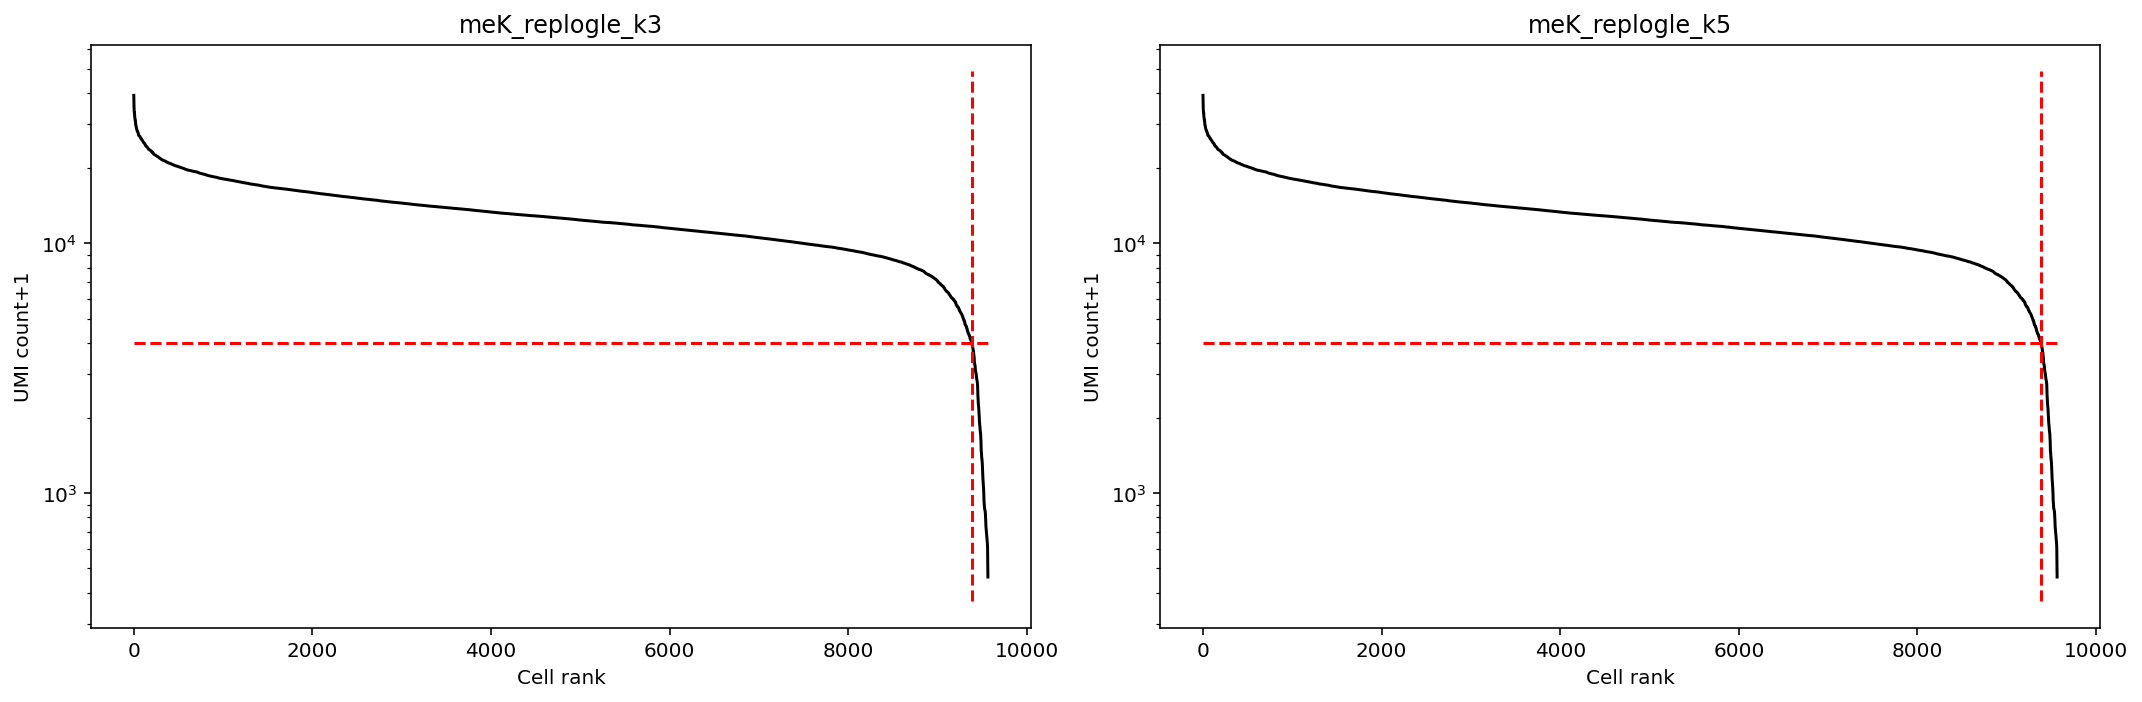

In [25]:
#Filter for cell barcodes with reasonable UMI threshold, and filter for cells in selected conditions
cf = []
thr_lb = [4e3]*num_ks #4e3,Set UMI count filter for each K run

fig1,ax1 = plt.subplots(1,num_ks,figsize=(15,5))

bcs = bars
n_cells = S.shape[0]


for k in range(num_ks):
    filename = loom_filepaths[k]
    dataset_name = dataset_names[k]


    #Make knee plot with S+U counts
#     monod.preprocess.knee_plot(S.T[final_filt,:]+U.T[final_filt,:],ax1[k],viz=True,thr=thr_lb[k])
#     cf_ = ((S.T[final_filt,:]+U.T[final_filt,:]).sum(0)>thr_lb[k])
    monod.preprocess.knee_plot(S.T+U.T,ax1[k],viz=True,thr=thr_lb[k])
    cf_ = ((S.T+U.T).sum(0)>thr_lb[k])

    #Make filter for low count barcodes
    n_annot_bcs = len(meta['cell_barcode'])
    annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
    annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
    print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')

    #Select for barcodes in selected conditions, if applicable
    annot_bcs = meta[(meta['guide_identity'].isin(ctrls))]['cell_barcode'] #previously filt_ids with ctrls, conds_only
    cf.append(np.isin(bcs,annot_bcs) & cf_)
    print(f'{len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')


    ax1[k].set_title(dataset_name)

!mkdir ./figs
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_replogle_meK.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)



## **Create Output Files and Run meK-Means**

In [344]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [345]:
!mkdir ./fits

mkdir: cannot create directory ‘./fits’: File exists


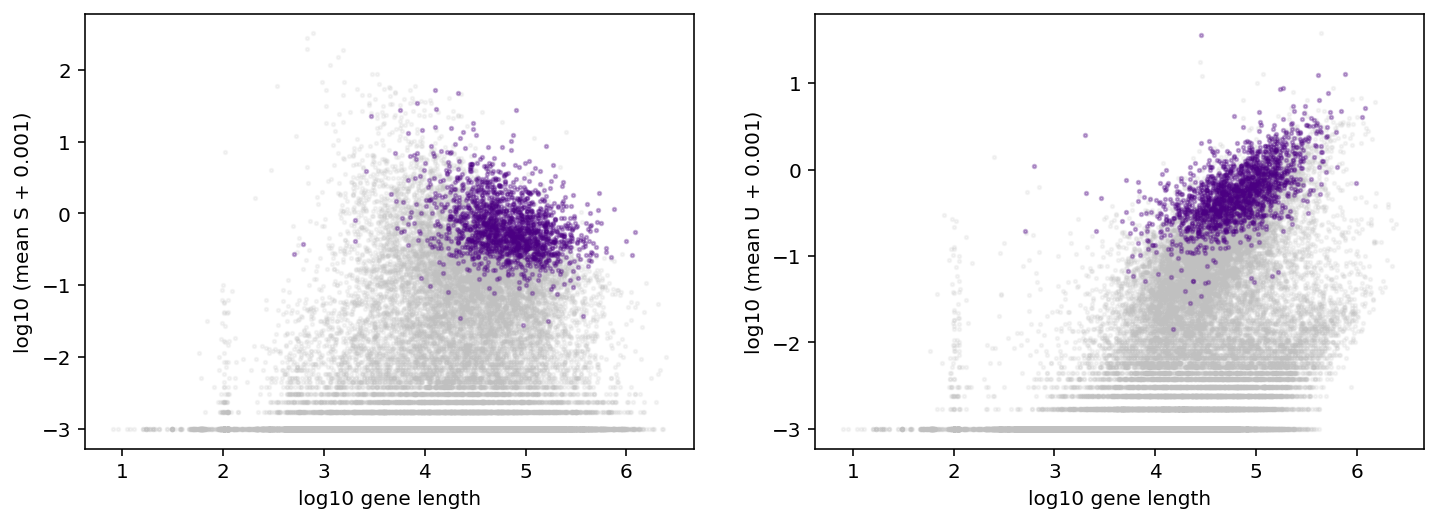

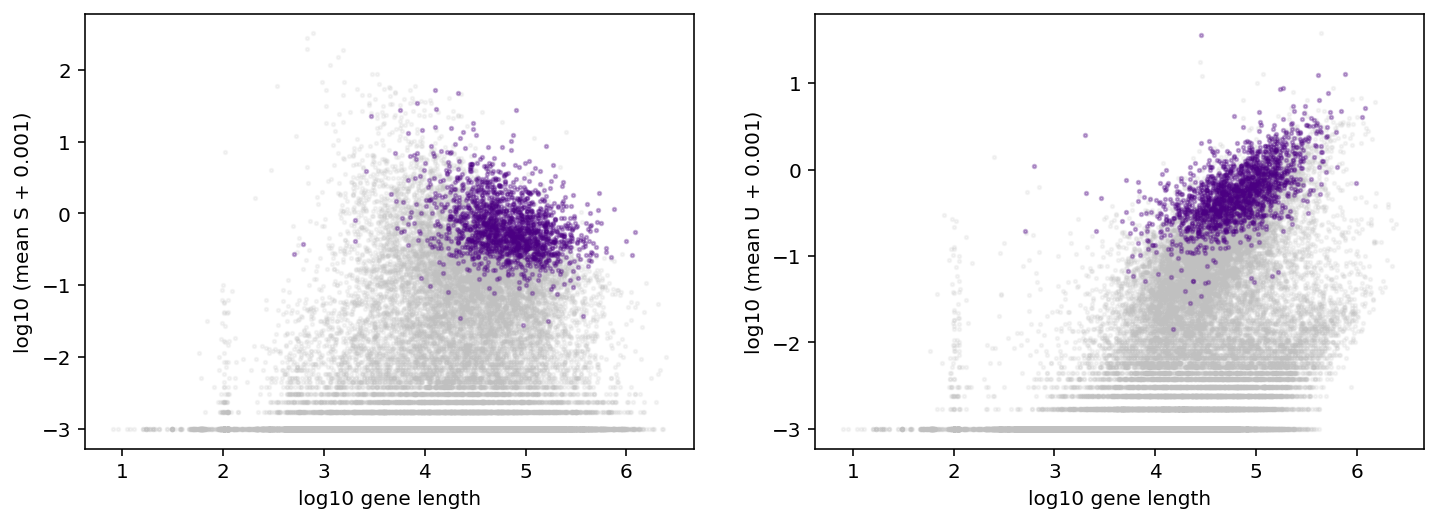

In [26]:
#Select to run inference on, same genes selected across all runs
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='meK_replogle',batch_id=1,\
                                             datestring='230925', n_genes=len(all_gs_forinf),\
                                             exp_filter_threshold=None,cf=cf,
                                                            genes_to_fit=all_gs_forinf) # genes_to_fit=all_gs_forinf


Save selected genes to genes.csv instead, for meK-Means

In [61]:
# new_pd = pd.DataFrame(columns=range(len(all_gs_forinf)))
# new_pd.loc[0] = all_gs_forinf
# new_pd.to_csv('./fits/gg_230917_025_meK_norman_1/genes.csv',header=None,index=None)
# new_pd.head()

In [27]:
test = pd.read_csv('./fits/gg_230925_025_meK_replogle_1/genes.csv',header=None)
test.head()

,0,1,2,3,4,5,6,7,8,9,...,614,615,616,617,618,619,620,621,622,623
0,PLOD1,CLCA1,MFN2,RSRP1,CLSPN,SESN2,PUM1,TUT4,TAF5L,RC3H1,...,RBM41,SH3BGRL,BRWD3,PGK1,ATRX,HDAC8,OGT,GATA1,APOO,SH3KBP1


**Run meK-Means**

In [28]:
#Set bounds from physical parameters search space
phys_lb = [-2.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 2.5]


samp_lb = [-6.894736842105264, -1.25]
samp_ub = [-6.894736842105264, -1.25]

gridsize = [1,1]

In [29]:
#Set number of epochs
epochs = 10

In [65]:
# saveCounts

In [30]:
result_strings = []
for i in range(num_ks):

    #Define model with bursty transcription and Poisson molecule capture/sampling
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    #Set up mminference parameters
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':5,'init_pattern':'moments','num_restarts':1})

    #Read in loom file with filtered barcodes
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    #Run inference(fit_all_grid_points()) and Save result file strings
    full_result_string = inference_parameters.fit_all_grid_points(30,search_data) 

    result_strings.append(full_result_string)
    
    

ERROR! Session/line number was not unique in database. History logging moved to new session 441


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:40<00:00, 13.37s/it]


mstep self.weights:  [0.13622033 0.38890994 0.47486974]
Q Function:  -1647044.729863347



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:40<00:00, 20.29s/it]


mstep self.weights:  [2.82159775e-04 5.52365254e-01 4.47352586e-01]
Q Function:  -1694040.314178004



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:40<00:00, 20.28s/it]


mstep self.weights:  [6.92528480e-10 4.92665435e-01 5.07334564e-01]
Q Function:  -1665477.0932615567



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:40<00:00, 20.15s/it]


mstep self.weights:  [6.92520775e-10 5.12723602e-01 4.87276397e-01]
Q Function:  -1669714.6021460919



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:40<00:00, 20.40s/it]


mstep self.weights:  [6.92520774e-10 5.41989595e-01 4.58010404e-01]
Q Function:  -1641855.5729766989



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:41<00:00, 20.77s/it]


mstep self.weights:  [6.92520774e-10 5.66699588e-01 4.33300411e-01]
Q Function:  -1667366.5656682828



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:41<00:00, 20.85s/it]


mstep self.weights:  [6.92520774e-10 6.07042276e-01 3.92957724e-01]
Q Function:  -1650764.9054526477



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:41<00:00, 20.56s/it]


mstep self.weights:  [6.92520774e-10 8.24444953e-01 1.75555047e-01]
Q Function:  -1641977.9840504087



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:40<00:00, 20.37s/it]


mstep self.weights:  [6.92520774e-10 8.36300799e-01 1.63699201e-01]
Q Function:  -1665819.3232164006



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:40<00:00, 20.49s/it]


mstep self.weights:  [6.92520774e-10 8.95427174e-01 1.04572825e-01]
Q Function:  -1662734.1411041087



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.39s/it]


mstep self.weights:  [0.08162961 0.06828602 0.16087004 0.31308589 0.37612843]
Q Function:  -1660110.0712403338



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:46<00:00,  9.28s/it]


mstep self.weights:  [0.0797328  0.02130596 0.19618656 0.27493661 0.42783807]
Q Function:  -1716167.2420677315



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:45<00:00,  9.16s/it]


mstep self.weights:  [0.10448791 0.00583567 0.01718691 0.04998093 0.82250858]
Q Function:  -1649013.39391363



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:45<00:00, 15.31s/it]


mstep self.weights:  [2.63355498e-01 6.92521466e-04 6.92533099e-10 6.92520773e-10
 7.35951979e-01]
Q Function:  -1631678.1264106343



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:41<00:00, 20.52s/it]


mstep self.weights:  [7.63389820e-02 6.92520773e-10 6.92520773e-10 6.92521348e-10
 9.23661016e-01]
Q Function:  -1637658.693392173



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:41<00:00, 20.60s/it]


mstep self.weights:  [3.85327643e-02 6.92520773e-10 6.92520773e-10 6.92544385e-10
 9.61467234e-01]
Q Function:  -1624669.116306813



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:41<00:00, 20.56s/it]


mstep self.weights:  [4.85061327e-02 6.92520773e-10 6.92520773e-10 6.92520773e-10
 9.51493865e-01]
Q Function:  -1647789.7376540643



  0%|                                                                                                                                   | 0/2 [00:04<?, ?it/s]

Process ForkPoolWorker-577:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process ForkPoolWorker-579:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing

Process ForkPoolWorker-586:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process ForkPoolWorker-599:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing

Process ForkPoolWorker-596:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process ForkPoolWorker-597:
Traceback (most recent call last):
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tchari/miniconda3/envs/py37/lib/python3.7/multiprocessing

UnboundLocalError: local variable 'x' referenced before assignment

In [353]:
#DOes more genes --> more clusters? Try doubling to top 200?

#Read in result files for K=1,5,7 runs
sr = []
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings]]

sr

INFO:root:Grid scan results loaded from ./fits/gg_230925_025_meK_replogle_1/meK_replogle_k3/Bursty_Poisson_1x1/grid_scan_results_0.res.
INFO:root:Grid scan results loaded from ./fits/gg_230925_025_meK_replogle_1/meK_replogle_k3/Bursty_Poisson_1x1/grid_scan_results_1.res.
INFO:root:Grid scan results loaded from ./fits/gg_230925_025_meK_replogle_1/meK_replogle_k5/Bursty_Poisson_1x1/grid_scan_results_2.res.


[[<monod.mminference.SearchResults at 0x7fd1c4775950>,

In [354]:
raws = [d_string+'/raw.sd' for d_string in dataset_strings]
sd = [monod.analysis.load_search_data(w) for w in raws]
sd

INFO:root:Search data loaded from ./fits/gg_230925_025_meK_replogle_1/meK_replogle_k3/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230925_025_meK_replogle_1/meK_replogle_k5/raw.sd.


## **Assess Results of meK-Means**

In [355]:
def vis_metrics(results,title,ks,figsize=(18, 5),s=50,save_file=None):
    '''
    Visualize -Q function and KLD over epochs, and -AIC for final model inference

    results: list of len num_ks, of lists of SearchResults objs per K tested (e.g. [[SearchResults],[SearchResults,SearchResults]] for K=1&2)
    title: title string for leftmost, plot
    ks: list of ks tested (e.g. [1,2])
    figsize: tuple for size of figure
    s: size of dots in scatterplot
    save_file: string, output file to save image

  '''

    num_ks = len(results)
    sets = []
    qs = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()

    aic = []
    fin_k = []
    kls = []

    epoch = len(results[0][0].all_qs.flatten())
    epos = list(range(1,epoch+1))*num_ks

    for i in range(num_ks):

        qs += list(-1*results[i][0].all_qs.flatten())
        sets += [ks[i]]*epoch
        aic += [results[i][0].aic[0]]
        fin_k += [len(results[i])]


        concat_klds = []
        ks_used = []
        for r in results[i]:
            concat_klds += [r.all_klds[0,:,:]]
            ks_used += [r.assigns]

        concat_klds = np.array(concat_klds)
        concat_klds = concat_klds.reshape((concat_klds.shape[1], concat_klds.shape[2],concat_klds.shape[0]))

        kls += list(np.mean(np.sum(concat_klds[:,:,:],axis=1),axis=1)) #Sum of klds across k clusters


    res['Q'] = qs
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]

    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k

    #Plot Q function over epochs
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)

    sns.lineplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    g1=sns.scatterplot(data=res,x='epoch',y='Q',hue='setting',
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('-Q')
    ax[0].legend(
          title='Set K')
    ax[0].set_title(title)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1, 1))


    #Plot klds over epochs
    g2=sns.lineplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting',
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')
    ax[1].legend(
          title='Set K')
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1, 1))



    #Plot aics
    g3=sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final Assigned k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='Set K')
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)


In [356]:
#Plot cluster concordance with true labels and distribution of clusters

def vis_assign(assign,true=None,title='',figsize=(18, 5),save_file=None):
    '''
    Plot distribution of cluster assignments (optional: with previous annotations)

    assign: np.array of cluster assignments (1..k) for each cell
    true: list of user-given cluster assignments (string) for each cell, optional
    title: title string for cluster assignment plot
    figsize: tuple for size of figure
    save_file: string, output file to save image

    '''

    true_copy = list(true)
    assign_copy = list(assign)

    #Plot cluster assignments and distribution of sizes of each cluster
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    if true is not None:
        hues = true
    else:
        hues = assign_copy

    g= sns.histplot(x=assign,hue=hues,hue_order=list(np.unique(hues)), kde=False,ax=ax,
                    palette='tab20',multiple="dodge",
                    discrete=True)

    plt.xticks(np.arange(0,np.max(assign)+1))


    ax.set_xlabel('meK-Means Cluster Assignment')
    ax.set_title(title)
    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))


    plt.tight_layout()
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)



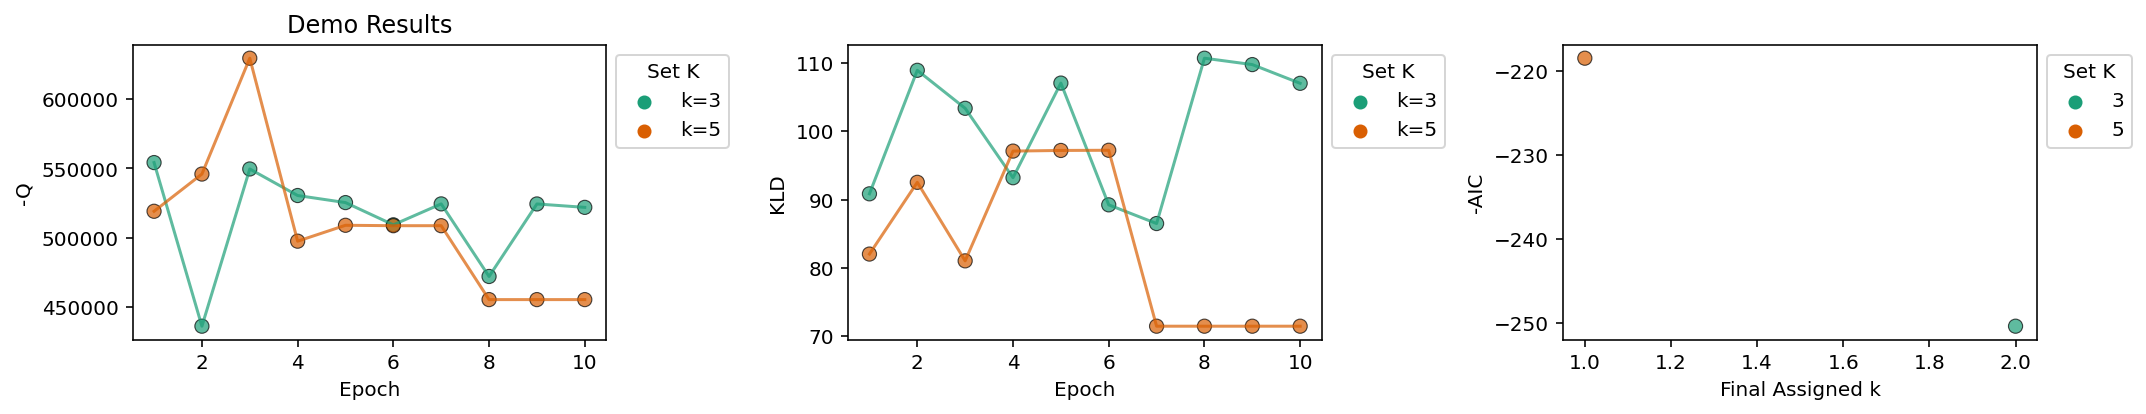

In [357]:
vis_metrics(sr,'Demo Results',ks,figsize=(15,3))

In [358]:
#Concatenate cell cluster assignments across all cells and cluster result files
mek_assigns = []
for which_res in range(len(sr)):
    k_res = sr[which_res] #Get all result files for model
    cat_assigns = np.array([None]*int(np.sum(cf[which_res]))) #cat_assigns is empty list of length = no. cell barcodes (after umi filtering)
    for i in range(len(k_res)):
        r = k_res[i]
        cat_assigns[r.filt] = r.assigns #denotes with cluster k cells were assigned to

    mek_assigns += [cat_assigns]

len(mek_assigns)

2

In [359]:
#Get 'original' cell type assignments for the filtered barcodes/cells, from Yao et al. 2021
all_assigns = [list(meta['guide_identity'][meta['cell_barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(all_assigns))

2085


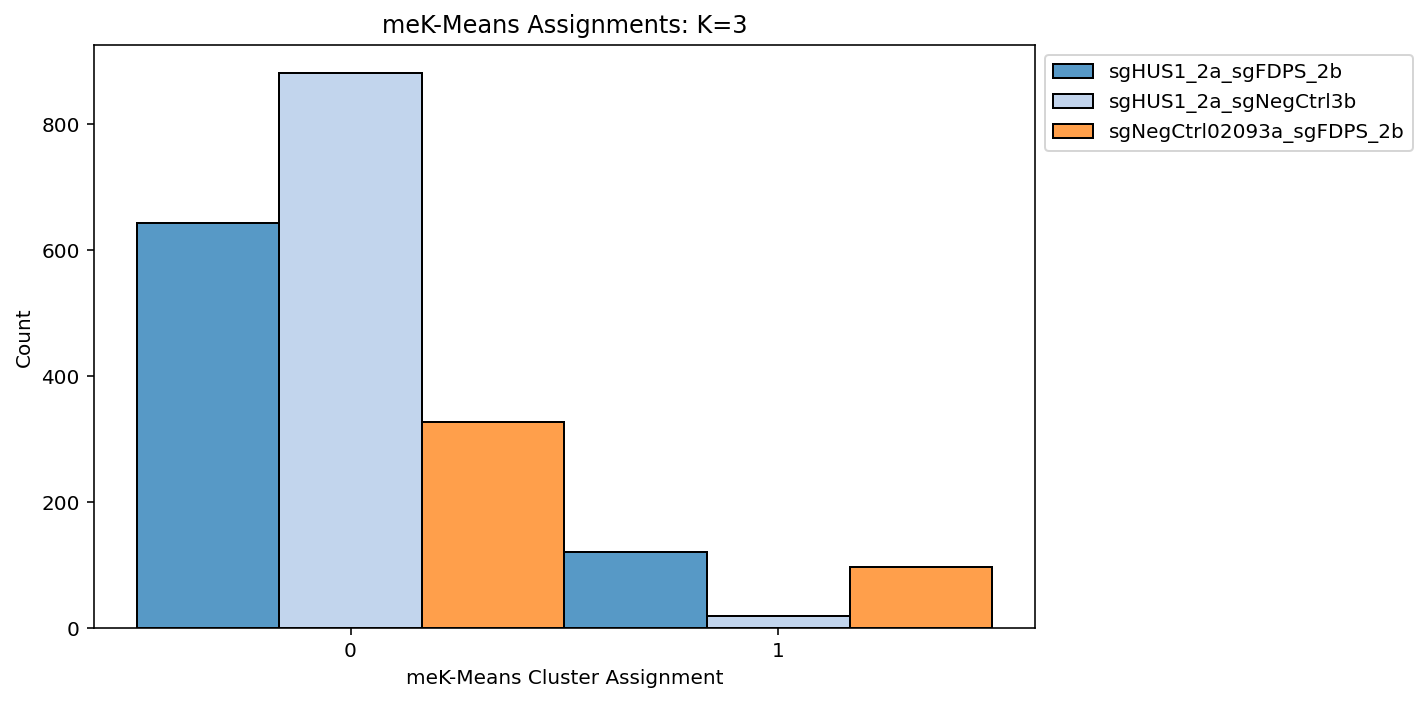

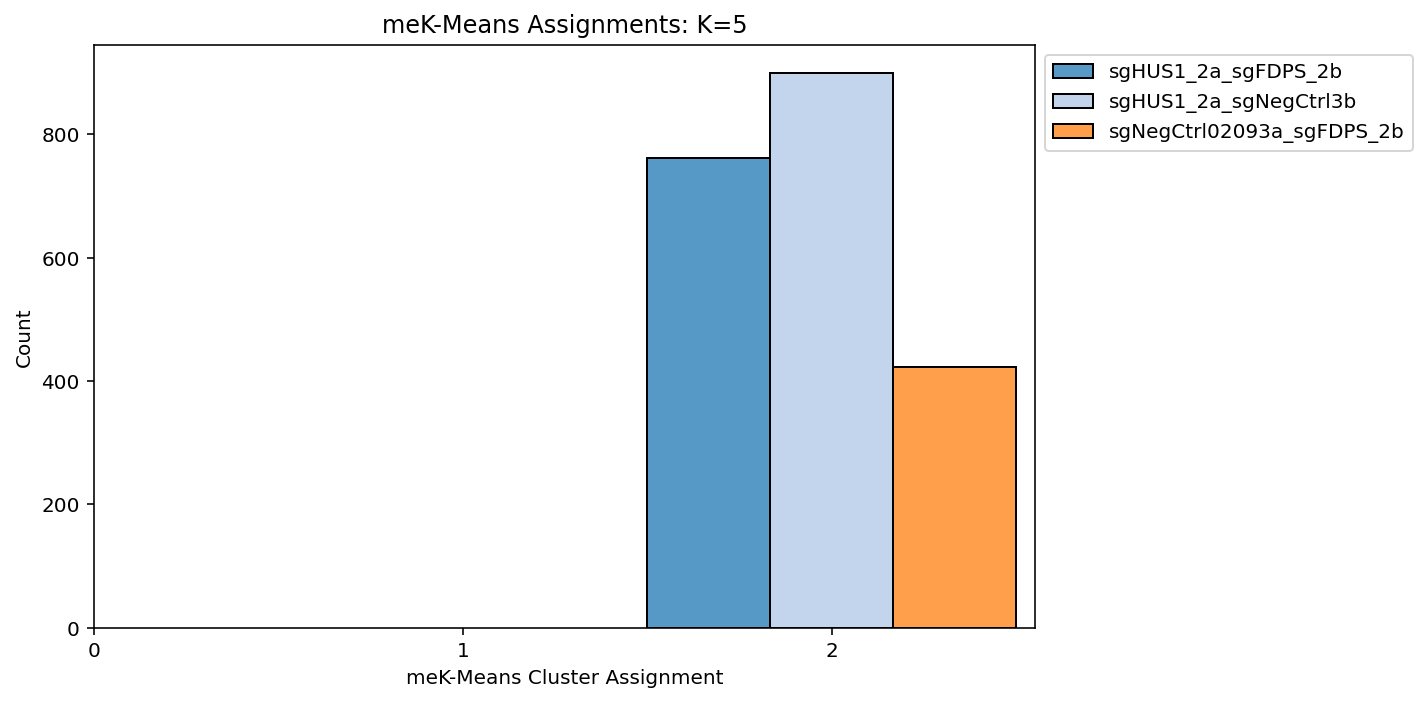

In [360]:
for i in range(len(mek_assigns)):
    m = mek_assigns[i]
    vis_assign(m,true=all_assigns,title='meK-Means Assignments: K='+str(ks[i]),figsize=(10,5))

In [361]:
from sklearn.cluster import KMeans

In [362]:
# new_S = search_data.layers[0,:,:]
# S_t = new_S.T
# tots = np.sum(S_t,axis=1)
# divids = (1e4/tots)[:,None]
# S_t = S_t*divids
# S_t = np.log1p(S_t)

# kmeans = KMeans(n_clusters=5, random_state=0).fit(S_t)
# labs = kmeans.labels_


In [363]:
new_S = search_data.layers[1,:,:]
S_t = new_S.T
tots = np.sum(S_t,axis=1)
divids = (1e4/tots)[:,None]
S_t = S_t*divids
S_t = np.log1p(S_t)

kmeans = KMeans(n_clusters=3, random_state=0).fit(S_t)
labs2 = kmeans.labels_


In [364]:
# sns.histplot(x=labs2,hue=labs,palette='tab20',multiple='dodge')

<AxesSubplot:ylabel='Count'>

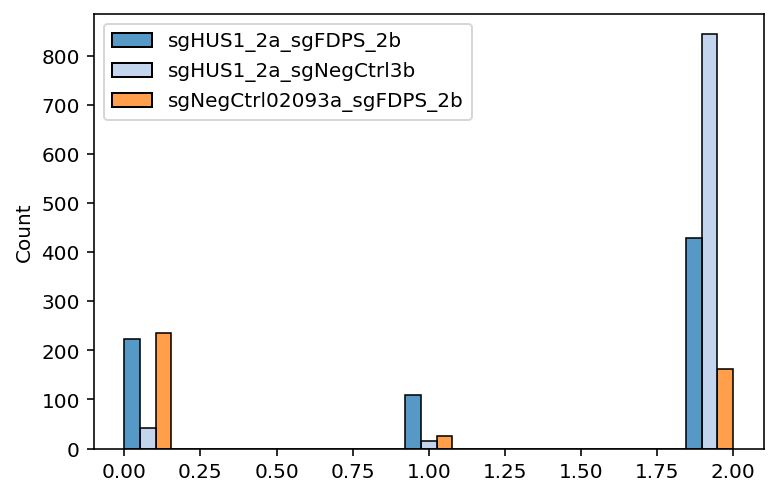

In [365]:
sns.histplot(x=labs2,hue=all_assigns,palette='tab20',multiple='dodge')


In [366]:
import igraph as ig
import leidenalg as la
from sklearn.neighbors import kneighbors_graph

A = kneighbors_graph(S_t, 30, mode='connectivity', include_self=True)
sources, targets = A.nonzero()
weights = A[sources, targets]
if isinstance(weights, np.matrix):
    weights = weights.A1
g = ig.Graph(directed=False) #True in scanpy, which is odd
g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
g.add_edges(list(zip(sources, targets)))

g.es['weight'] = weights

partition_type = la.RBConfigurationVertexPartition


part = la.find_partition(g, partition_type, 
                                weights=np.array(g.es['weight']).astype(np.float64), 
                                n_iterations=-1, resolution_parameter=1.0)


labels = np.array(part.membership)
    

<AxesSubplot:ylabel='Count'>

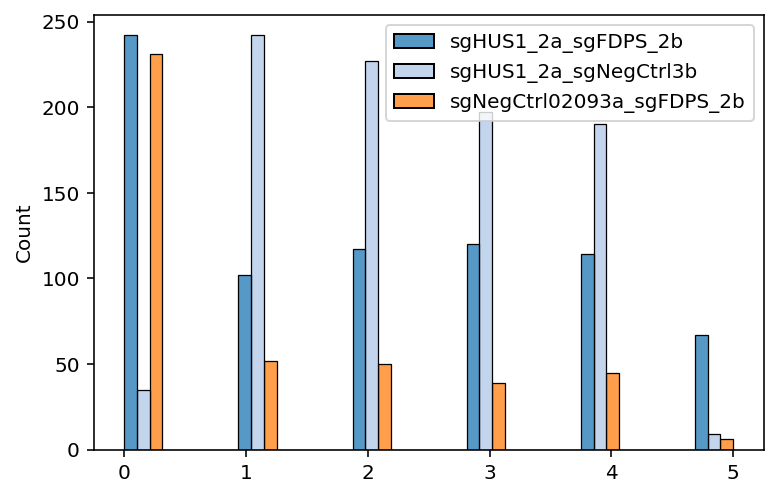

In [367]:
sns.histplot(x=labels,hue=all_assigns,palette='tab20',multiple='dodge')